## This analysis is using the first day exposed users as cohort to evaluate how much impact Chat Channel product to Reddit users.


In [1]:
!pip install google-cloud-bigquery
!pip install psmpy
# !pip install ace_tools

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
from google.cloud import bigquery

# Query large BQ table
project_id = 'data-prod-165221'
client = bigquery.Client(project=project_id)

Authenticated


# SQL

In [2]:
sql = '''
 SELECT
    *
  FROM
    `data-prod-165221.ds_v2_gold_tables.wjfeng_tmp_20240329_bets_chat_channels_holdout_exposed_users_step4`
  WHERE 1=1
    AND user_logged_in = 1
    AND app_install = 1
    AND (ios_l1 > 0 OR android_l1 > 0)

'''
df = client.query(sql).to_dataframe()


sql = '''
select * from `data-prod-165221.ds_v2_gold_tables.wjfeng_tmp_20240329_bets_chat_channels_holdout_tos`
'''

tos = client.query(sql).to_dataframe()

data frame size:
(224857, 21)
holdout group size
is_cc_active
0    112279
dtype: int64
non-holdout group size
is_cc_active
0    111067
1      1131
dtype: int64
df_prep size:
Accuracy: 0.8285, ROC AUC: 0.8617, F1-score: 0.0870


<ipython-input-3-5bc8d26d5cb3>:82: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=predicted_df[predicted_df['is_treatment']==0], x='propensity_score', shade=True,
<ipython-input-3-5bc8d26d5cb3>:84: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=predicted_df[predicted_df['is_treatment']==1], x='propensity_score', shade=True,
<ipython-input-3-5bc8d26d5cb3>:91: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=predicted_df[predicted_df['is_treatment']==0], x='propensity_logit', shade=True,
<ipython-input-3-5bc8d26d5cb3>:93: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This wil

Elapsed time: 584.578327 seconds


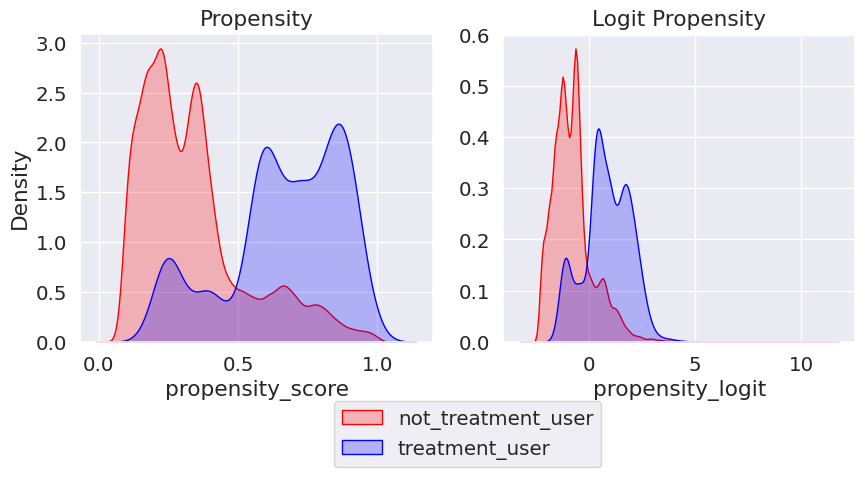

In [3]:
print('data frame size:')
print(df.shape)


from sklearn.preprocessing import OrdinalEncoder

# Create an OrdinalEncoder instance
encoder = OrdinalEncoder()

df['geo_dummy'] = encoder.fit_transform(df[['geo']])


# separate holdout and non-holdout group
print("holdout group size")
df_holdout = df[(df['experiment_variant'] == 'holdout') & (df['is_cc_active'] == 0)]

print(df_holdout.groupby('is_cc_active').size())

df_treatment = df[(df['experiment_variant'] == 'control_1')]
print("non-holdout group size")
print(df_treatment.groupby('is_cc_active').size())

# release more RAM by deleting table no longer use
del df

## --------------------------------------------------------------------------------------------------------

"""
build a data frame including ony:
[holdout] holdout group: non-Chat Channel active users
[treatment] non-holdout group: Chat Channel active users ONLY
"""
df1 = df_treatment[df_treatment.is_cc_active==1]
df0 = df_holdout[df_holdout.is_cc_active==0]
frames = [df0, df1]
df_prep = pd.concat(frames)
print('df_prep size:')
df_prep.shape


# identifying two groups by assigning 0 or 1 to two group
df_test = df_prep.copy()
df_test['is_treatment'] = df_test['experiment_variant'].apply(lambda x: 0 if x == 'holdout' else 1)
# df_test = df_test.drop(columns=['experiment_variant','first_exposure_timestamp','is_cc_active']) # without geo
# df_test = df_test.drop(columns=['experiment_variant','first_exposure_timestamp','is_cc_active','geo'])
df_test = df_test.drop(columns=['experiment_variant','first_exposure_timestamp','is_cc_active','geo'])
df_test = df_test.fillna(0)

from psmpy import PsmPy
from psmpy.functions import cohenD
import psmpy.plotting

# Predict Propensity Scores
psm = PsmPy(df_test, treatment='is_treatment', indx='user_id')
psm.logistic_ps(balance = True)

## --------------------------------------------------------------------------------------------------------

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

# Add prediction column
predicted_df = psm.predicted_data
threshold = 0.5
predicted_df['pred'] = np.where(predicted_df['propensity_score']>=threshold, 1, 0)

# Assess the model
print(f"Accuracy: {np.mean(predicted_df['is_treatment']==predicted_df['pred']):.4f},\
 ROC AUC: {roc_auc_score(predicted_df['is_treatment'], predicted_df['propensity_score']):.4f},\
 F1-score: {f1_score(predicted_df['is_treatment'], predicted_df['pred']):.4f}")

# Visualise confusion matrix
pd.crosstab(predicted_df['is_treatment'], predicted_df['pred']).rename(columns={0: False, 1:True})

## --------------------------------------------------------------------------------------------------------

import seaborn as sns

fig, ax = plt.subplots(1,2, figsize=(10,4))

# Visualise propensity
sns.kdeplot(data=predicted_df[predicted_df['is_treatment']==0], x='propensity_score', shade=True,
            color='red', label='not_treatment_user', ax=ax[0])
sns.kdeplot(data=predicted_df[predicted_df['is_treatment']==1], x='propensity_score', shade=True,
            color='blue', label='treatment_user', ax=ax[0])
ax[0].set_title('Propensity')
ax[0].legend(loc='center', bbox_to_anchor=(1.1, -0.3))


# Visualise logit propensity
sns.kdeplot(data=predicted_df[predicted_df['is_treatment']==0], x='propensity_logit', shade=True,
            color='red', label='not_treatment_user', ax=ax[1])
sns.kdeplot(data=predicted_df[predicted_df['is_treatment']==1], x='propensity_logit', shade=True,
            color='blue', label='treatment_user', ax=ax[1])
ax[1].set_title('Logit Propensity')
ax[1].set_ylabel("");



## --------------------------------------------------------------------------------------------------------

import time
# record the start time
start_time = time.perf_counter()

# Perform KNN Matching on Propensity Scores
psm.predicted_data.replace([np.inf, -np.inf], np.nan, inplace=True)
psm.predicted_data.dropna(inplace=True)
psm.knn_matched_12n(matcher='propensity_logit', how_many=1)

# record the end time
end_time = time.perf_counter()
# calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.6f} seconds")





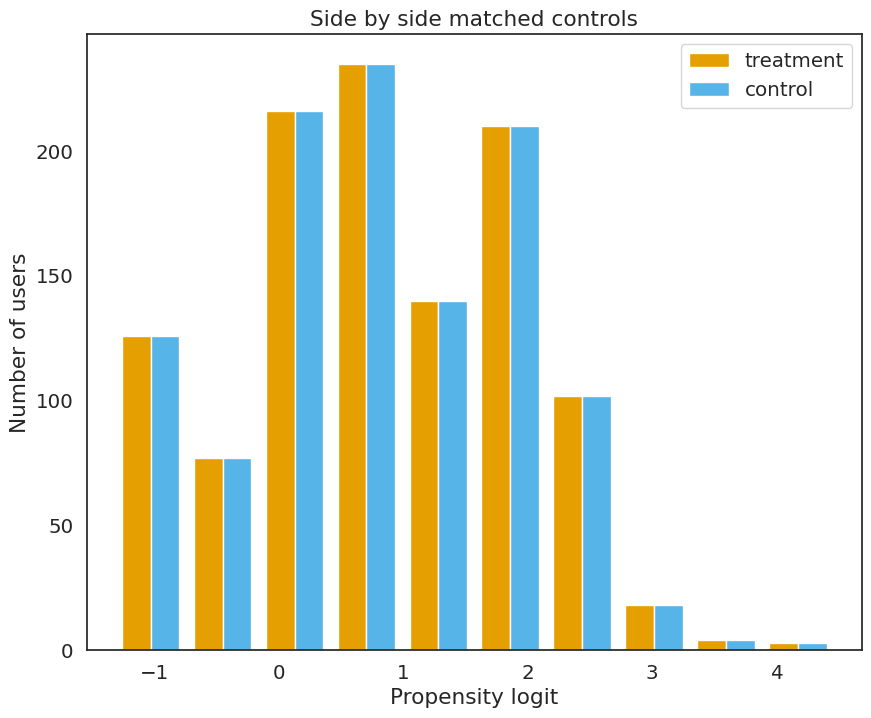

In [4]:

## --------------------------------------------------------------------------------------------------------

# Plot Propensity Scores
psm.plot_match(Title='Side by side matched controls', Ylabel='Number of users', Xlabel= 'Propensity logit', names = ['treatment', 'control'], save=True)

View Matched IDs Table:
(1131, 2)


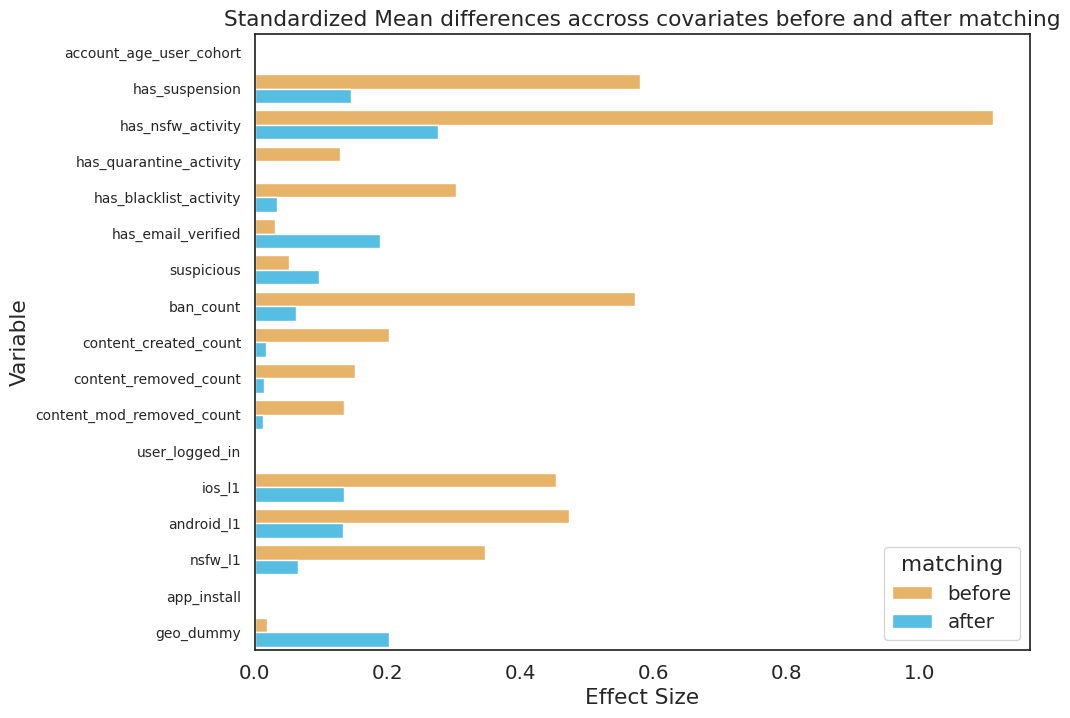

Elapsed time: 1.471085 seconds


In [7]:
# View Matched IDs Table (Optional)
print("View Matched IDs Table:")
print(psm.matched_ids.shape)


import matplotlib.pyplot as plt

# Generate the plot using psm.effect_size_plot
psm.effect_size_plot(save=True)

# Get the current axis
ax = plt.gca()

# Customize the y-axis font size
ax.tick_params(axis='y', labelsize=10)  # Adjust 'labelsize' to your desired font size

# Save the figure if required
plt.savefig('effect_size_plot.png')

# Show the plot (optional)
plt.show()


## --------------------------------------------------------------------------------------------------------


import time
# record the start time
start_time = time.perf_counter()

# Assume psm.df_matched and psm.matched_ids are already defined DataFrames

# Creating dataframe for PSM matching treatment/control group users
psm.df_matched['group'] = np.where(psm.df_matched['user_id'].isin(psm.matched_ids['user_id']), 'treatment', 'control')
df_psm_group = psm.df_matched[['user_id', 'group']].drop_duplicates()

# mapping the TOS data
df1 = tos.copy()

# Optimize by getting unique values and creating a DataFrame of all possible combinations
all_combinations = pd.MultiIndex.from_product([df1['pt'].unique(), df_psm_group['user_id'].unique()], names=['pt', 'user_id']).to_frame(index=False)

# Merge all_combinations with df1 to get the time on site data
df3 = pd.merge(all_combinations, df1, on=['pt', 'user_id'], how='left')

# Merge df3 with df_psm_group to add the group information
df3 = pd.merge(df3, df_psm_group, on='user_id', how='left')

# Fill NaN values based on column type
df3['tos'] = df3['tos'].astype('float').fillna(0)

# Release more RAM by deleting table no longer used
# del tos

# Convert 'group' to a categorical type for better memory usage and performance
df3['group'] = df3['group'].astype('category')


# record the end time
end_time = time.perf_counter()
# calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.6f} seconds")



Overall Metrics:
group
control               2.391035e+03
treatment             3.197884e+03
absolute_delta        8.068483e+02
relative_delta        3.374473e+01
p_value               5.931348e-38
treatment_ci_lower    3.101472e+03
treatment_ci_upper    3.294295e+03
Name: tos, dtype: float64


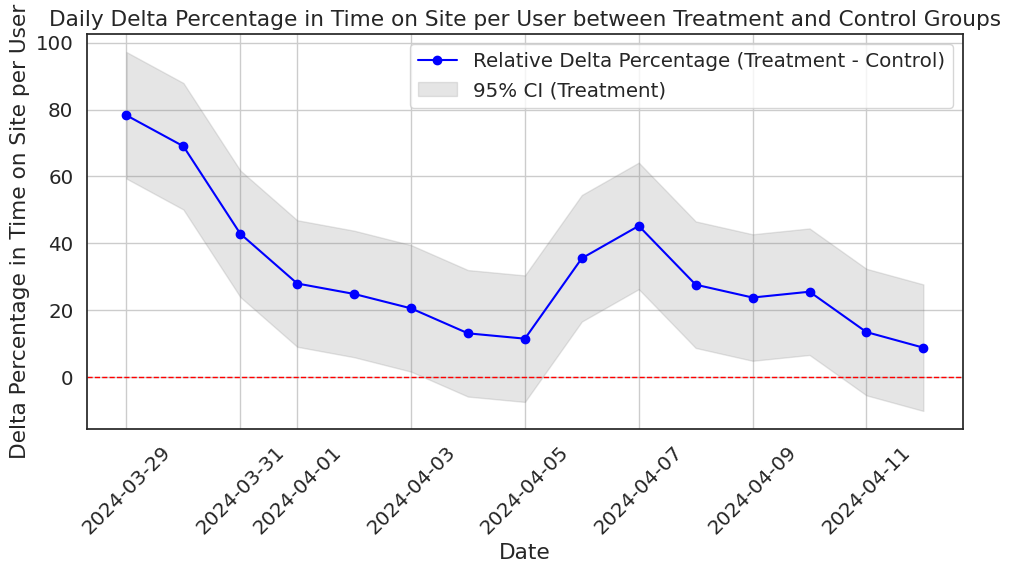

group,control,treatment,absolute_delta,relative_delta,treatment_ci,control_ci
pt,,,,,,
2024-03-29,3885.112290,6925.563564,3040.451274,78.259032,18.933802,10.49572
2024-03-30,2748.646331,4645.340340,1896.694010,69.004658,18.933802,10.49572
2024-03-31,2576.410256,3679.551552,1103.141295,42.816989,18.933802,10.49572
2024-04-01,2630.172414,3364.615616,734.443202,27.923766,18.933802,10.49572
2024-04-02,2528.996463,3156.090090,627.093627,24.796145,18.933802,10.49572
2024-04-03,2516.657825,3032.173173,515.515348,20.484126,18.933802,10.49572
2024-04-04,2415.572060,2729.951952,314.379892,13.014718,18.933802,10.49572
2024-04-05,2326.336870,2591.876877,265.540007,11.414512,18.933802,10.49572
2024-04-06,1978.529620,2680.479479,701.949860,35.478360,18.933802,10.49572


In [8]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, norm
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from IPython.display import display



# Winsorize the data
df3['tos'] = winsorize(df3['tos'], limits=[0.05, 0.05])

# Calculate the overall average time on site per user for each group
overall_avg_tos = df3.groupby('group')['tos'].mean()

# Calculate the absolute delta for the overall period
overall_avg_tos['absolute_delta'] = overall_avg_tos['treatment'] - overall_avg_tos['control']

# Calculate the relative delta percentage for the overall period
overall_avg_tos['relative_delta'] = (overall_avg_tos['absolute_delta'] / overall_avg_tos['control']) * 100

# Calculate the p-value for the overall period
treatment_data = df3[df3['group'] == 'treatment']['tos']
control_data = df3[df3['group'] == 'control']['tos']
_, overall_p_value = ttest_ind(treatment_data, control_data, equal_var=False, nan_policy='omit')

overall_avg_tos['p_value'] = overall_p_value

# Calculate means and standard errors
means = df3.groupby('group')['tos'].mean()
std_errors = df3.groupby('group')['tos'].std() / np.sqrt(df3.groupby('group')['tos'].count())

# Calculate confidence intervals for delta percentage
confidence_level = 0.95
z_score = norm.ppf((1 + confidence_level) / 2)
treatment_mean = means['treatment']
treatment_se = std_errors['treatment']

# Calculate the confidence interval bounds for the treatment group
overall_avg_tos['treatment_ci_lower'] = treatment_mean - z_score * treatment_se
overall_avg_tos['treatment_ci_upper'] = treatment_mean + z_score * treatment_se

# Print overall metrics
print("Overall Metrics:")
print(overall_avg_tos)

# Plotting (for each day if needed for comparison)
daily_avg_tos = df3.groupby(['pt', 'group'])['tos'].mean().unstack()

# Calculate the absolute delta
daily_avg_tos['absolute_delta'] = daily_avg_tos['treatment'] - daily_avg_tos['control']

# Calculate the relative delta percentage
daily_avg_tos['relative_delta'] = (daily_avg_tos['absolute_delta'] / daily_avg_tos['control']) * 100

# Calculate means and standard errors for daily data
means = daily_avg_tos.mean()
std_errors = daily_avg_tos.std() / np.sqrt(daily_avg_tos.count())

# Calculate confidence intervals for delta percentage for daily data
daily_avg_tos['treatment_ci'] = z_score * (std_errors['treatment'] / means['treatment']) * 100
daily_avg_tos['control_ci'] = z_score * (std_errors['control'] / means['control']) * 100

# Plotting
plt.figure(figsize=(10, 6))

# Plot delta percentage
plt.plot(daily_avg_tos.index, daily_avg_tos['relative_delta'], label='Relative Delta Percentage (Treatment - Control)', color='blue', marker='o')

# Plot confidence interval
plt.fill_between(daily_avg_tos.index, daily_avg_tos['relative_delta'] - daily_avg_tos['treatment_ci'], daily_avg_tos['relative_delta'] + daily_avg_tos['treatment_ci'],
                 color='gray', alpha=0.2, label='95% CI (Treatment)')

plt.axhline(0, color='red', linestyle='--', linewidth=1)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Delta Percentage in Time on Site per User')
plt.title('Daily Delta Percentage in Time on Site per User between Treatment and Control Groups')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

# Display the daily metrics
display(daily_avg_tos)


# Comments

In [9]:
sql = '''
with u as (
  SELECT
    *
  FROM
    `data-prod-165221.ds_v2_gold_tables.wjfeng_tmp_20240329_bets_chat_channels_holdout_exposed_users_step4`
  WHERE
    1=1
    AND user_logged_in = 1
    AND app_install = 1
    AND (ios_l1 > 0
      OR android_l1 > 0)
)

SELECT
  date(pt) pt,
  user_id,
  sum(comments) comments,
  sum(posts) posts
FROM
  `data-prod-165221.all_reddit.user_daily_votes_comments_posts`
WHERE
  date(pt) >= '2024-03-29' and date(pt) <= '2024-03-29' + 14
  and user_id in (select user_id from u)
group by 1,2
'''

comments_posts = client.query(sql).to_dataframe()

Elapsed time: 15.389417 seconds
Overall Metrics:
group
control               4.795756e-01
treatment             8.711378e-01
absolute_delta        3.915622e-01
relative_delta        8.164765e+01
p_value               7.834910e-14
treatment_ci_lower    7.901568e-01
treatment_ci_upper    9.521188e-01
Name: comments, dtype: float64


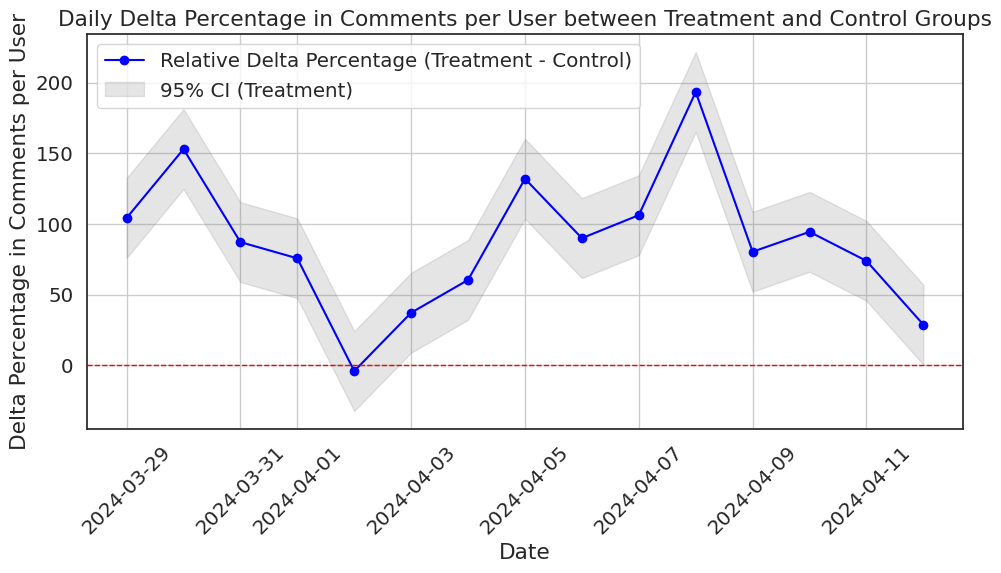

group,control,treatment,absolute_delta,relative_delta,treatment_ci,control_ci
pt,,,,,,
2024-03-29,1.175950,2.402402,1.226452,104.294520,28.212969,25.896222
2024-03-30,0.557029,1.409409,0.852380,153.022546,28.212969,25.896222
2024-03-31,0.511052,0.956957,0.445905,87.252304,28.212969,25.896222
2024-04-01,0.521662,0.916917,0.395255,75.768311,28.212969,25.896222
2024-04-02,0.782493,0.751752,-0.030742,-3.928674,28.212969,25.896222
2024-04-03,0.643678,0.883884,0.240206,37.317675,28.212969,25.896222
2024-04-04,0.450928,0.723724,0.272795,60.496379,28.212969,25.896222
2024-04-05,0.338638,0.785786,0.447147,132.042748,28.212969,25.896222
2024-04-06,0.346596,0.658659,0.312063,90.036465,28.212969,25.896222


In [10]:


# mapping the comments data
df1 = comments_posts.copy()


# Optimize by getting unique values and creating a DataFrame of all possible combinations
all_combinations = pd.MultiIndex.from_product([df1['pt'].unique(), df_psm_group['user_id'].unique()], names=['pt', 'user_id']).to_frame(index=False)


# Merge all_combinations with df1 to get the Comments data
df3 = pd.merge(all_combinations, df1, on=['pt', 'user_id'], how='left')


# Merge df3 with df_psm_group to add the group information
df3 = pd.merge(df3, df_psm_group, on='user_id', how='left')


# Fill NaN values based on column type
df3['comments'] = df3['comments'].astype('float').fillna(0)


# Release more RAM by deleting table no longer used
# del comments


# Convert 'group' to a categorical type for better memory usage and performance
df3['group'] = df3['group'].astype('category')




# record the end time
end_time = time.perf_counter()
# calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.6f} seconds")






## --------------------------------------------------------------------------------------------------------


import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, norm
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from IPython.display import display


# Winsorize the data
# df3['comments'] = winsorize(df3['comments'], limits=[0.05, 0.05])


# Calculate the overall average Comments per user for each group
overall_avg_comments = df3.groupby('group')['comments'].mean()


# Calculate the absolute delta for the overall period
overall_avg_comments['absolute_delta'] = overall_avg_comments['treatment'] - overall_avg_comments['control']


# Calculate the relative delta percentage for the overall period
overall_avg_comments['relative_delta'] = (overall_avg_comments['absolute_delta'] / overall_avg_comments['control']) * 100


# Calculate the p-value for the overall period
treatment_data = df3[df3['group'] == 'treatment']['comments']
control_data = df3[df3['group'] == 'control']['comments']
_, overall_p_value = ttest_ind(treatment_data, control_data, equal_var=False, nan_policy='omit')


overall_avg_comments['p_value'] = overall_p_value


# Calculate means and standard errors
means = df3.groupby('group')['comments'].mean()
std_errors = df3.groupby('group')['comments'].std() / np.sqrt(df3.groupby('group')['comments'].count())


# Calculate confidence intervals for delta percentage
confidence_level = 0.95
z_score = norm.ppf((1 + confidence_level) / 2)
treatment_mean = means['treatment']
treatment_se = std_errors['treatment']


# Calculate the confidence interval bounds for the treatment group
overall_avg_comments['treatment_ci_lower'] = treatment_mean - z_score * treatment_se
overall_avg_comments['treatment_ci_upper'] = treatment_mean + z_score * treatment_se


# Print overall metrics
print("Overall Metrics:")
print(overall_avg_comments)


# Plotting (for each day if needed for comparison)
daily_avg_comments = df3.groupby(['pt', 'group'])['comments'].mean().unstack()


# Calculate the absolute delta
daily_avg_comments['absolute_delta'] = daily_avg_comments['treatment'] - daily_avg_comments['control']


# Calculate the relative delta percentage
daily_avg_comments['relative_delta'] = (daily_avg_comments['absolute_delta'] / daily_avg_comments['control']) * 100


# Calculate means and standard errors for daily data
means = daily_avg_comments.mean()
std_errors = daily_avg_comments.std() / np.sqrt(daily_avg_comments.count())


# Calculate confidence intervals for delta percentage for daily data
daily_avg_comments['treatment_ci'] = z_score * (std_errors['treatment'] / means['treatment']) * 100
daily_avg_comments['control_ci'] = z_score * (std_errors['control'] / means['control']) * 100


# Plotting
plt.figure(figsize=(10, 6))


# Plot delta percentage
plt.plot(daily_avg_comments.index, daily_avg_comments['relative_delta'], label='Relative Delta Percentage (Treatment - Control)', color='blue', marker='o')


# Plot confidence interval
plt.fill_between(daily_avg_comments.index, daily_avg_comments['relative_delta'] - daily_avg_comments['treatment_ci'], daily_avg_comments['relative_delta'] + daily_avg_comments['treatment_ci'],
                color='gray', alpha=0.2, label='95% CI (Treatment)')


plt.axhline(0, color='red', linestyle='--', linewidth=1)


# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Delta Percentage in Comments per User')
plt.title('Daily Delta Percentage in Comments per User between Treatment and Control Groups')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)


# Display the plot
plt.tight_layout()
plt.show()


# Display the daily metrics
display(daily_avg_comments)





# Post

Elapsed time: 16.059747 seconds
Overall Metrics:
group
control                0.150663
treatment              0.232432
absolute_delta         0.081769
relative_delta        54.272935
p_value                0.000012
treatment_ci_lower     0.200179
treatment_ci_upper     0.264686
Name: posts, dtype: float64


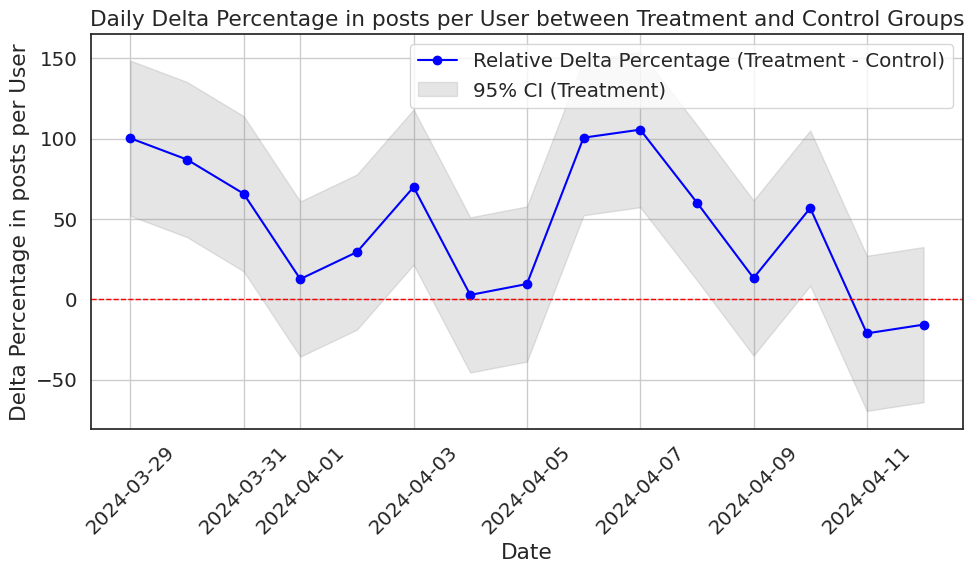

group,control,treatment,absolute_delta,relative_delta,treatment_ci,control_ci
pt,,,,,,
2024-03-29,0.477454,0.955956,0.478502,100.219664,48.271508,33.88291
2024-03-30,0.251105,0.469469,0.218364,86.961257,48.271508,33.88291
2024-03-31,0.183024,0.303303,0.120279,65.717892,48.271508,33.88291
2024-04-01,0.159151,0.179179,0.020028,12.584251,48.271508,33.88291
2024-04-02,0.142352,0.184184,0.041832,29.386529,48.271508,33.88291
2024-04-03,0.109637,0.186186,0.076549,69.819820,48.271508,33.88291
2024-04-04,0.123784,0.127127,0.003343,2.700558,48.271508,33.88291
2024-04-05,0.107869,0.118118,0.010249,9.501305,48.271508,33.88291
2024-04-06,0.092838,0.186186,0.093348,100.549121,48.271508,33.88291


In [11]:
# mapping the posts data
df1 = comments_posts.copy()

# Optimize by getting unique values and creating a DataFrame of all possible combinations
all_combinations = pd.MultiIndex.from_product([df1['pt'].unique(), df_psm_group['user_id'].unique()], names=['pt', 'user_id']).to_frame(index=False)

# Merge all_combinations with df1 to get the posts data
df3 = pd.merge(all_combinations, df1, on=['pt', 'user_id'], how='left')

# Merge df3 with df_psm_group to add the group information
df3 = pd.merge(df3, df_psm_group, on='user_id', how='left')

# Fill NaN values based on column type
df3['posts'] = df3['posts'].astype('float').fillna(0)

# Release more RAM by deleting table no longer used
# del posts

# Convert 'group' to a categorical type for better memory usage and performance
df3['group'] = df3['group'].astype('category')


# record the end time
end_time = time.perf_counter()
# calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.6f} seconds")

## --------------------------------------------------------------------------------------------------------

import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, norm
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from IPython.display import display

# Winsorize the data
# df3['posts'] = winsorize(df3['posts'], limits=[0.05, 0.05])

# Calculate the overall average posts per user for each group
overall_avg_posts = df3.groupby('group')['posts'].mean()

# Calculate the absolute delta for the overall period
overall_avg_posts['absolute_delta'] = overall_avg_posts['treatment'] - overall_avg_posts['control']

# Calculate the relative delta percentage for the overall period
overall_avg_posts['relative_delta'] = (overall_avg_posts['absolute_delta'] / overall_avg_posts['control']) * 100

# Calculate the p-value for the overall period
treatment_data = df3[df3['group'] == 'treatment']['posts']
control_data = df3[df3['group'] == 'control']['posts']
_, overall_p_value = ttest_ind(treatment_data, control_data, equal_var=False, nan_policy='omit')

overall_avg_posts['p_value'] = overall_p_value

# Calculate means and standard errors
means = df3.groupby('group')['posts'].mean()
std_errors = df3.groupby('group')['posts'].std() / np.sqrt(df3.groupby('group')['posts'].count())

# Calculate confidence intervals for delta percentage
confidence_level = 0.95
z_score = norm.ppf((1 + confidence_level) / 2)
treatment_mean = means['treatment']
treatment_se = std_errors['treatment']

# Calculate the confidence interval bounds for the treatment group
overall_avg_posts['treatment_ci_lower'] = treatment_mean - z_score * treatment_se
overall_avg_posts['treatment_ci_upper'] = treatment_mean + z_score * treatment_se

# Print overall metrics
print("Overall Metrics:")
print(overall_avg_posts)

# Plotting (for each day if needed for comparison)
daily_avg_posts = df3.groupby(['pt', 'group'])['posts'].mean().unstack()

# Calculate the absolute delta
daily_avg_posts['absolute_delta'] = daily_avg_posts['treatment'] - daily_avg_posts['control']

# Calculate the relative delta percentage
daily_avg_posts['relative_delta'] = (daily_avg_posts['absolute_delta'] / daily_avg_posts['control']) * 100

# Calculate means and standard errors for daily data
means = daily_avg_posts.mean()
std_errors = daily_avg_posts.std() / np.sqrt(daily_avg_posts.count())

# Calculate confidence intervals for delta percentage for daily data
daily_avg_posts['treatment_ci'] = z_score * (std_errors['treatment'] / means['treatment']) * 100
daily_avg_posts['control_ci'] = z_score * (std_errors['control'] / means['control']) * 100

# Plotting
plt.figure(figsize=(10, 6))

# Plot delta percentage
plt.plot(daily_avg_posts.index, daily_avg_posts['relative_delta'], label='Relative Delta Percentage (Treatment - Control)', color='blue', marker='o')

# Plot confidence interval
plt.fill_between(daily_avg_posts.index, daily_avg_posts['relative_delta'] - daily_avg_posts['treatment_ci'], daily_avg_posts['relative_delta'] + daily_avg_posts['treatment_ci'],
               color='gray', alpha=0.2, label='95% CI (Treatment)')

plt.axhline(0, color='red', linestyle='--', linewidth=1)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Delta Percentage in posts per User')
plt.title('Daily Delta Percentage in posts per User between Treatment and Control Groups')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

# Display the daily metrics
display(daily_avg_posts)

In [12]:
sql = '''
with u as (
  SELECT
    *
  FROM
    `data-prod-165221.ds_v2_gold_tables.wjfeng_tmp_20240329_bets_chat_channels_holdout_exposed_users_step4`
  WHERE
    1=1
    AND user_logged_in = 1
    AND app_install = 1
    AND (ios_l1 > 0
      OR android_l1 > 0)
)

SELECT
  date(pt) pt,
  user_id,
  sum(comments_consumed) comments_consumed,
  sum(posts_consumed) posts_consumed
FROM
  `data-prod-165221.growth_team_tables.user_post_comment_consume_attributes_agg`
WHERE
  date(pt) >= '2024-03-29' and date(pt) <= '2024-03-29' + 14
  and user_id in (select user_id from u)
group by 1,2
'''

cp_consumed = client.query(sql).to_dataframe()

# comments / Post consumed

Elapsed time: 21.196985 seconds
Overall Metrics:
group
control               5.571176e-01
treatment             8.321321e-01
absolute_delta        2.750145e-01
relative_delta        4.936382e+01
p_value               2.278922e-12
treatment_ci_lower    7.702865e-01
treatment_ci_upper    8.939778e-01
Name: comments_consumed, dtype: float64


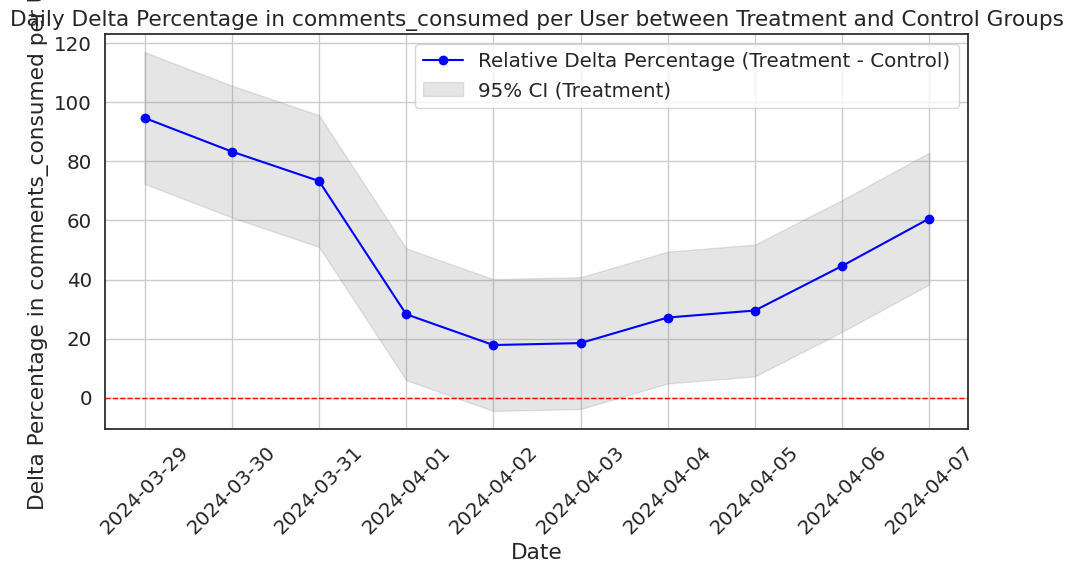

group,control,treatment,absolute_delta,relative_delta,treatment_ci,control_ci
pt,,,,,,
2024-03-29,0.816976,1.590591,0.773614,94.692420,22.308387,12.870893
2024-03-30,0.589744,1.081081,0.491337,83.313749,22.308387,12.870893
2024-03-31,0.482759,0.836837,0.354078,73.344773,22.308387,12.870893
2024-04-01,0.619805,0.794795,0.174989,28.232941,22.308387,12.870893
2024-04-02,0.609195,0.717718,0.108522,17.814040,22.308387,12.870893
2024-04-03,0.589744,0.698699,0.108955,18.474997,22.308387,12.870893
2024-04-04,0.518126,0.658659,0.140533,27.123369,22.308387,12.870893
2024-04-05,0.479222,0.620621,0.141399,29.505890,22.308387,12.870893
2024-04-06,0.424403,0.613614,0.189210,44.582708,22.308387,12.870893


In [13]:
# mapping the comments_consumed data
df1 = cp_consumed.copy()


# Optimize by getting unique values and creating a DataFrame of all possible combinations
all_combinations = pd.MultiIndex.from_product([df1['pt'].unique(), df_psm_group['user_id'].unique()], names=['pt', 'user_id']).to_frame(index=False)


# Merge all_combinations with df1 to get the comments_consumed data
df3 = pd.merge(all_combinations, df1, on=['pt', 'user_id'], how='left')


# Merge df3 with df_psm_group to add the group information
df3 = pd.merge(df3, df_psm_group, on='user_id', how='left')


# Fill NaN values based on column type
df3['comments_consumed'] = df3['comments_consumed'].astype('float').fillna(0)


# Release more RAM by deleting table no longer used
# del comments_consumed


# Convert 'group' to a categorical type for better memory usage and performance
df3['group'] = df3['group'].astype('category')




# record the end time
end_time = time.perf_counter()
# calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.6f} seconds")


## --------------------------------------------------------------------------------------------------------


import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, norm
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from IPython.display import display


# Winsorize the data
# df3['comments_consumed'] = winsorize(df3['comments_consumed'], limits=[0.05, 0.05])


# Calculate the overall average comments_consumed per user for each group
overall_avg_comments_consumed = df3.groupby('group')['comments_consumed'].mean()


# Calculate the absolute delta for the overall period
overall_avg_comments_consumed['absolute_delta'] = overall_avg_comments_consumed['treatment'] - overall_avg_comments_consumed['control']


# Calculate the relative delta percentage for the overall period
overall_avg_comments_consumed['relative_delta'] = (overall_avg_comments_consumed['absolute_delta'] / overall_avg_comments_consumed['control']) * 100


# Calculate the p-value for the overall period
treatment_data = df3[df3['group'] == 'treatment']['comments_consumed']
control_data = df3[df3['group'] == 'control']['comments_consumed']
_, overall_p_value = ttest_ind(treatment_data, control_data, equal_var=False, nan_policy='omit')


overall_avg_comments_consumed['p_value'] = overall_p_value


# Calculate means and standard errors
means = df3.groupby('group')['comments_consumed'].mean()
std_errors = df3.groupby('group')['comments_consumed'].std() / np.sqrt(df3.groupby('group')['comments_consumed'].count())


# Calculate confidence intervals for delta percentage
confidence_level = 0.95
z_score = norm.ppf((1 + confidence_level) / 2)
treatment_mean = means['treatment']
treatment_se = std_errors['treatment']


# Calculate the confidence interval bounds for the treatment group
overall_avg_comments_consumed['treatment_ci_lower'] = treatment_mean - z_score * treatment_se
overall_avg_comments_consumed['treatment_ci_upper'] = treatment_mean + z_score * treatment_se


# Print overall metrics
print("Overall Metrics:")
print(overall_avg_comments_consumed)


# Plotting (for each day if needed for comparison)
daily_avg_comments_consumed = df3.groupby(['pt', 'group'])['comments_consumed'].mean().unstack()


# Calculate the absolute delta
daily_avg_comments_consumed['absolute_delta'] = daily_avg_comments_consumed['treatment'] - daily_avg_comments_consumed['control']


# Calculate the relative delta percentage
daily_avg_comments_consumed['relative_delta'] = (daily_avg_comments_consumed['absolute_delta'] / daily_avg_comments_consumed['control']) * 100


# Calculate means and standard errors for daily data
means = daily_avg_comments_consumed.mean()
std_errors = daily_avg_comments_consumed.std() / np.sqrt(daily_avg_comments_consumed.count())


# Calculate confidence intervals for delta percentage for daily data
daily_avg_comments_consumed['treatment_ci'] = z_score * (std_errors['treatment'] / means['treatment']) * 100
daily_avg_comments_consumed['control_ci'] = z_score * (std_errors['control'] / means['control']) * 100


# Plotting
plt.figure(figsize=(10, 6))


# Plot delta percentage
plt.plot(daily_avg_comments_consumed.index, daily_avg_comments_consumed['relative_delta'], label='Relative Delta Percentage (Treatment - Control)', color='blue', marker='o')


# Plot confidence interval
plt.fill_between(daily_avg_comments_consumed.index, daily_avg_comments_consumed['relative_delta'] - daily_avg_comments_consumed['treatment_ci'], daily_avg_comments_consumed['relative_delta'] + daily_avg_comments_consumed['treatment_ci'],
              color='gray', alpha=0.2, label='95% CI (Treatment)')


plt.axhline(0, color='red', linestyle='--', linewidth=1)


# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Delta Percentage in comments_consumed per User')
plt.title('Daily Delta Percentage in comments_consumed per User between Treatment and Control Groups')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)


# Display the plot
plt.tight_layout()
plt.show()


# Display the daily metrics
display(daily_avg_comments_consumed)





# posts consumed

Elapsed time: 22.118075 seconds
Overall Metrics:
group
control               1.326320e+02
treatment             1.559629e+02
absolute_delta        2.333086e+01
relative_delta        1.759067e+01
p_value               4.894148e-08
treatment_ci_lower    1.494179e+02
treatment_ci_upper    1.625078e+02
Name: posts_consumed, dtype: float64


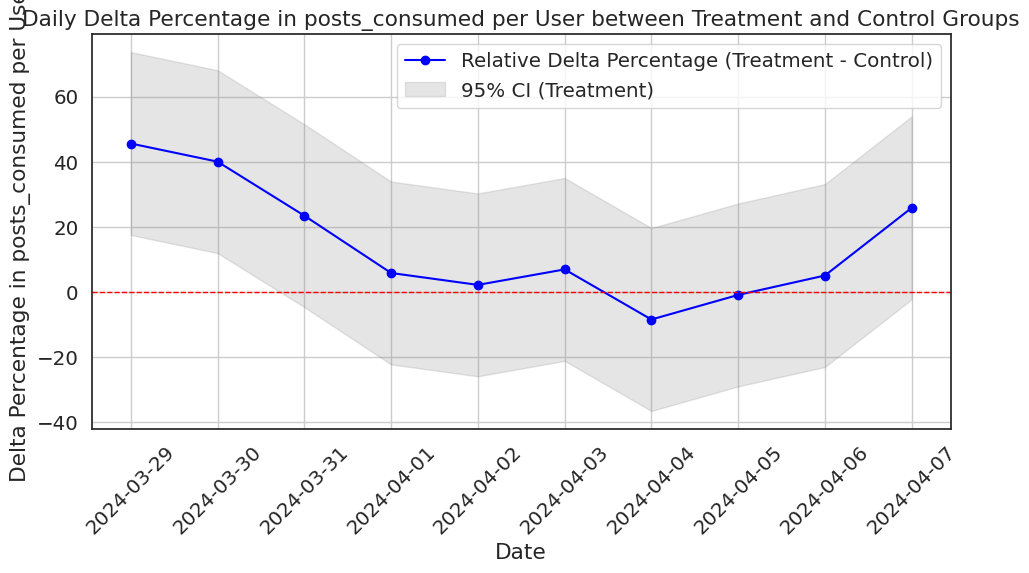

group,control,treatment,absolute_delta,relative_delta,treatment_ci,control_ci
pt,,,,,,
2024-03-29,234.194518,341.043043,106.848525,45.623837,28.064968,17.835373
2024-03-30,143.189213,200.538539,57.349325,40.051429,28.064968,17.835373
2024-03-31,126.615385,156.339339,29.723955,23.475784,28.064968,17.835373
2024-04-01,129.727675,137.354354,7.626680,5.878992,28.064968,17.835373
2024-04-02,131.007958,133.922923,2.914965,2.225029,28.064968,17.835373
2024-04-03,128.776304,137.760761,8.984457,6.976793,28.064968,17.835373
2024-04-04,119.657825,109.606607,-10.051218,-8.399967,28.064968,17.835373
2024-04-05,108.225464,107.293293,-0.932171,-0.861323,28.064968,17.835373
2024-04-06,106.778073,112.225225,5.447153,5.101378,28.064968,17.835373


In [14]:
# mapping the posts_consumed data
df1 = cp_consumed.copy()


# Optimize by getting unique values and creating a DataFrame of all possible combinations
all_combinations = pd.MultiIndex.from_product([df1['pt'].unique(), df_psm_group['user_id'].unique()], names=['pt', 'user_id']).to_frame(index=False)


# Merge all_combinations with df1 to get the posts_consumed data
df3 = pd.merge(all_combinations, df1, on=['pt', 'user_id'], how='left')


# Merge df3 with df_psm_group to add the group information
df3 = pd.merge(df3, df_psm_group, on='user_id', how='left')


# Fill NaN values based on column type
df3['posts_consumed'] = df3['posts_consumed'].astype('float').fillna(0)


# Release more RAM by deleting table no longer used
# del posts_consumed


# Convert 'group' to a categorical type for better memory usage and performance
df3['group'] = df3['group'].astype('category')




# record the end time
end_time = time.perf_counter()
# calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.6f} seconds")


## --------------------------------------------------------------------------------------------------------


import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, norm
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from IPython.display import display


# Winsorize the data
# df3['posts_consumed'] = winsorize(df3['posts_consumed'], limits=[0.05, 0.05])


# Calculate the overall average posts_consumed per user for each group
overall_avg_posts_consumed = df3.groupby('group')['posts_consumed'].mean()


# Calculate the absolute delta for the overall period
overall_avg_posts_consumed['absolute_delta'] = overall_avg_posts_consumed['treatment'] - overall_avg_posts_consumed['control']


# Calculate the relative delta percentage for the overall period
overall_avg_posts_consumed['relative_delta'] = (overall_avg_posts_consumed['absolute_delta'] / overall_avg_posts_consumed['control']) * 100


# Calculate the p-value for the overall period
treatment_data = df3[df3['group'] == 'treatment']['posts_consumed']
control_data = df3[df3['group'] == 'control']['posts_consumed']
_, overall_p_value = ttest_ind(treatment_data, control_data, equal_var=False, nan_policy='omit')


overall_avg_posts_consumed['p_value'] = overall_p_value


# Calculate means and standard errors
means = df3.groupby('group')['posts_consumed'].mean()
std_errors = df3.groupby('group')['posts_consumed'].std() / np.sqrt(df3.groupby('group')['posts_consumed'].count())


# Calculate confidence intervals for delta percentage
confidence_level = 0.95
z_score = norm.ppf((1 + confidence_level) / 2)
treatment_mean = means['treatment']
treatment_se = std_errors['treatment']


# Calculate the confidence interval bounds for the treatment group
overall_avg_posts_consumed['treatment_ci_lower'] = treatment_mean - z_score * treatment_se
overall_avg_posts_consumed['treatment_ci_upper'] = treatment_mean + z_score * treatment_se


# Print overall metrics
print("Overall Metrics:")
print(overall_avg_posts_consumed)


# Plotting (for each day if needed for comparison)
daily_avg_posts_consumed = df3.groupby(['pt', 'group'])['posts_consumed'].mean().unstack()


# Calculate the absolute delta
daily_avg_posts_consumed['absolute_delta'] = daily_avg_posts_consumed['treatment'] - daily_avg_posts_consumed['control']


# Calculate the relative delta percentage
daily_avg_posts_consumed['relative_delta'] = (daily_avg_posts_consumed['absolute_delta'] / daily_avg_posts_consumed['control']) * 100


# Calculate means and standard errors for daily data
means = daily_avg_posts_consumed.mean()
std_errors = daily_avg_posts_consumed.std() / np.sqrt(daily_avg_posts_consumed.count())


# Calculate confidence intervals for delta percentage for daily data
daily_avg_posts_consumed['treatment_ci'] = z_score * (std_errors['treatment'] / means['treatment']) * 100
daily_avg_posts_consumed['control_ci'] = z_score * (std_errors['control'] / means['control']) * 100


# Plotting
plt.figure(figsize=(10, 6))


# Plot delta percentage
plt.plot(daily_avg_posts_consumed.index, daily_avg_posts_consumed['relative_delta'], label='Relative Delta Percentage (Treatment - Control)', color='blue', marker='o')


# Plot confidence interval
plt.fill_between(daily_avg_posts_consumed.index, daily_avg_posts_consumed['relative_delta'] - daily_avg_posts_consumed['treatment_ci'], daily_avg_posts_consumed['relative_delta'] + daily_avg_posts_consumed['treatment_ci'],
              color='gray', alpha=0.2, label='95% CI (Treatment)')


plt.axhline(0, color='red', linestyle='--', linewidth=1)


# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Delta Percentage in posts_consumed per User')
plt.title('Daily Delta Percentage in posts_consumed per User between Treatment and Control Groups')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)


# Display the plot
plt.tight_layout()
plt.show()


# Display the daily metrics
display(daily_avg_posts_consumed)



